<a href="https://colab.research.google.com/github/ozj1/Cheminformatics_projects/blob/main/predicting_toxicity_and_solubility_of_molecules/toxicity_solubility_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install deepchem

In [ ]:
pip install tensorflow

In [ ]:
pip install rdkit

In [7]:
import numpy as np
import deepchem as dc
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21()

[20:19:07] WARNING: not removing hydrogen atom without neighbors
[20:19:21] WARNING: not removing hydrogen atom without neighbors


In [8]:
print(tox21_tasks)

['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']


In [9]:
train_dataset, valid_dataset, test_dataset = tox21_datasets

In [10]:
#dataset is not balanced, so we would need to balance the dataset.  
#the transformer object used by default is a balancing transformer.
#we have a MultiClass Classification problem
print(transformers)


In [11]:
#model training
model = dc.models.MultitaskClassifier(n_tasks=12, n_features=1024, layer_sizes=[1000], dropouts=0.25)
model.fit(train_dataset, nb_epoch=10)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
train_scores = model.evaluate(train_dataset, [metric], transformers)
test_scores = model.evaluate(test_dataset, [metric], transformers)

In [14]:
print(train_scores)
print(test_scores)

{'mean-roc_auc_score': 0.9648104215798003}
{'mean-roc_auc_score': 0.6767138978788451}


In [15]:
#now predicting the solubility of molecules
#we use the delaney dataset from MoleculeNet

# load the featurized data 
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
# Split into traintest-validation dataset
train_dataset, valid_dataset, test_dataset = datasets
# Fit the model
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)
model.fit(train_dataset, nb_epoch=100)
# Use r2 score as model evaluation metric
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print(model.evaluate(train_dataset, [metric], transformers))
print(model.evaluate(test_dataset, [metric], transformers))

{'pearson_r2_score': 0.9235682299899222}
{'pearson_r2_score': 0.6207297895760404}


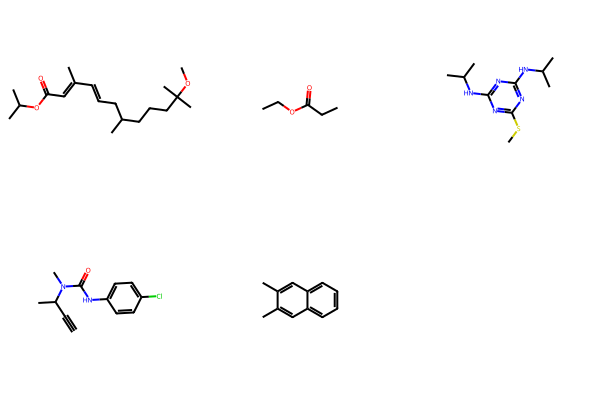

In [28]:
# prediction of solubility for a new set of molecules
# slimes represntation of the molecule
smiles_list = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
'CCOC(=O)CC',
'CSc1nc(NC(C)C)nc(NC(C)C)n1',
'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
'Cc1cc2ccccc2cc1C']

from rdkit import Chem
from rdkit.Chem import Draw

mol_list = [Chem.MolFromSmiles(smiles, sanitize=True) for smiles in smiles_list]
Draw.MolsToGridImage(mol_list)

In [39]:
#featurizing these new set of molecules from their SMILES format
from rdkit import Chem
mols = [Chem.MolFromSmiles(s) for s in smiles_list]
featurizer = dc.feat.ConvMolFeaturizer()
x = featurizer.featurize(mols)
predicted_solubility = model.predict_on_batch(x)
#the predicted solubility values
predicted_solubility

array([[-0.05103258],
       [ 1.3770894 ],
       [ 1.3172933 ],
       [ 0.74251586]], dtype=float32)

In [32]:
#extra visualizations

# To gain a visual understanding of compounds in our dataset, let's draw them using rdkit. We define a couple of helper functions to get started
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display
def display_images(filenames):
    """Helper to pretty-print images."""
    for file in filenames:
          display(Image(file))
def mols_to_pngs(mols, basename="test"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

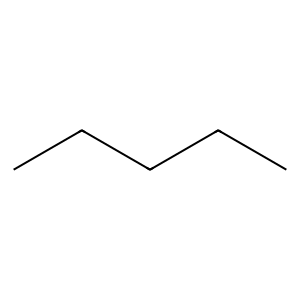

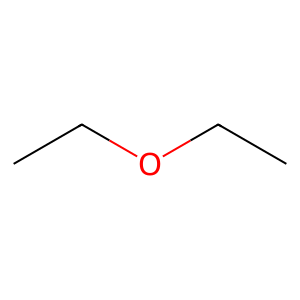

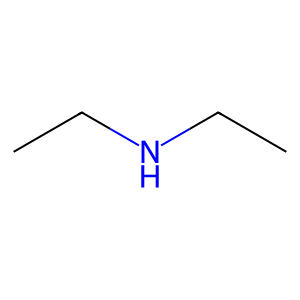

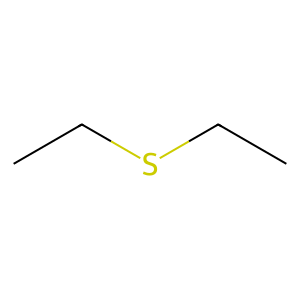

In [34]:
# forming visual structures from the SMILES string
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
smiles_list = ["CCCCC","CCOCC","CCNCC","CCSCC"]
mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
display_images(mols_to_pngs(mol_list))

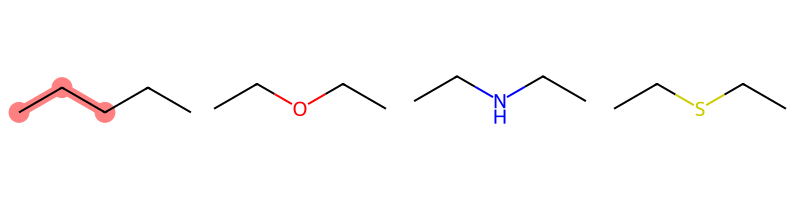

In [35]:
#we want to query SMILES string that has three adjacent carbons.
query = Chem.MolFromSmarts("CCC")
match_list = [mol.GetSubstructMatch(query) for mol in mol_list]
MolsToGridImage(mols=mol_list, molsPerRow=4, highlightAtomLists=match_list)
#the highlighted part represents the compound with three adjacent carbons.

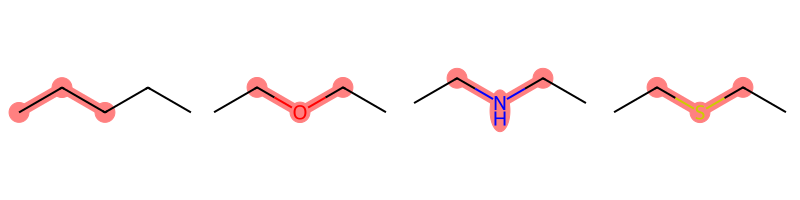

In [36]:
#now query for two carbons
query = Chem.MolFromSmarts("C*C")
match_list = [mol.GetSubstructMatch(query) for mol in
mol_list]
MolsToGridImage(mols=mol_list, molsPerRow=4,
highlightAtomLists=match_list)

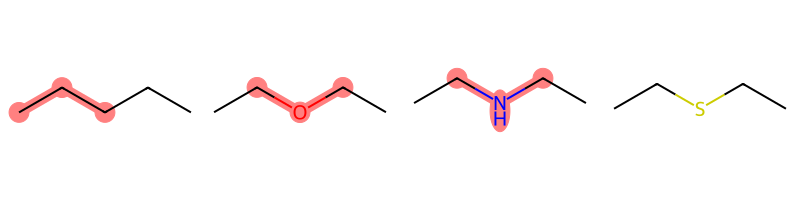

In [38]:
#another substructure query, two carbons and C or O or N in between
query = Chem.MolFromSmarts("C[C,N,O]C")
match_list = [mol.GetSubstructMatch(query) for mol in
mol_list]
MolsToGridImage(mols=mol_list, molsPerRow=4,
highlightAtomLists=match_list)